## Data Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans

df = pd.read_csv('sales.csv', delimiter=',', header = 0)
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


## Widget Prep

In [88]:
import difflib
import random
import requests
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display, clear_output
import warnings

warnings.filterwarnings('ignore')

def multi_checkbox_widget(descriptions):
    """ Widget with a search field and lots of checkboxes """
    options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
    options = [options_dict[description] for description in descriptions]
    options_widget = widgets.VBox(options)
    multi_select = widgets.VBox([options_widget])
    return multi_select

## Runner

In [188]:
def uncat(x, cat):
    dict_cats = {
        'Branch': {0 : 'A', 1: 'B', 2: 'C'},
        'Customer type': {0 : 'Member', 1: 'Normal'},
        'Gender': {0 : 'Female', 1: 'Male'},
        'Product line': {0 : 'Electronic accessories', 1: 'Fashion accessories', 2: 'Food and beverages', 3: 'Health and beauty', 4: 'Home and lifestyle', 5: 'Sports and travel'},
        'Payment': {0 : 'Cash', 1: 'Credit card', 2: 'Ewallet'}
    }
    c1 = int(x)
    c2 = c1 + 1
    p2 = np.around(x % 1, 2)
    p1 = 1 - p2
    if np.allclose(p1, 1, 0.001) == True:
        out = f'{int(p1 * 100)}% {dict_cats[cat][c1]}'
    else:
        out = f'{int(p1 * 100)}% {dict_cats[cat][c1]} <> {int(p2 * 100)}% {dict_cats[cat][c2]}'
    return(out)

def map_distribution(df):
    cat_features = ['Branch', 'Customer type', 'Gender', 'Product line', 'Payment']
    for c_name, _ in df.iteritems():
        if c_name in cat_features:
            df[c_name] = df[c_name].apply(lambda x: uncat(x, c_name))
    return(df)

def clustering(self):
    # get value
    global c_select
    
    # reduce to selected features
    selected_features = [w.description for w in w_fselect.children[0].children if w.value]
    
    if len(selected_features) == 0:
        with res_out:
            clear_output()
            print('No input given!')
    else:
        dff = df[selected_features]

        # transform columns
        cat_features = ['Branch', 'Customer type', 'Gender', 'Product line', 'Payment']
        for f in selected_features:
            if f in cat_features:
                dff[f] = dff[f].astype('category').cat.codes

        # normalize
        X = dff.values 
        min_max_scaler = preprocessing.MinMaxScaler()
        X_scaled = min_max_scaler.fit_transform(X)
        df_norm = pd.DataFrame(X_scaled)
        df_norm.columns = dff.columns

        # k-means
        kmeans_model = KMeans(n_clusters=c_select.value)
        kmeans_model.fit(df_norm.values)
        centers = np.array(kmeans_model.cluster_centers_)

        # inverse normalize
        X_out = min_max_scaler.inverse_transform(centers)
        X_out = np.around(X_out, 2)
        df_out = pd.DataFrame(X_out)
        df_out.columns = dff.columns
        
        # transform categories
        df_out = map_distribution(df_out)

        with res_out:
            clear_output()
            display(df_out)

## Clustering

In [189]:
features = ['Branch', 'Customer type', 'Gender', 'Product line', 'Unit price', 'Quantity', 'cogs', 'Payment', 'Rating']
result = []

w_fselect = multi_checkbox_widget(features)

global c_select
c_select = widgets.IntSlider(
    value=4,
    min=1,
    max=10,
    step=1,
    description='Clusters:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
runner = widgets.Button(description="Calc")
runner.on_click(clustering)
out = widgets.Output(layout={'border': '1px solid black'})
res_out = widgets.Output(layout={'border': '0px solid black'})

with out:
    hbox0 = HBox([runner, c_select])
    hbox1 = HBox([w_fselect, res_out])
    display(VBox([hbox0, hbox1]))
out

Output(layout=Layout(border='1px solid black'))

## Steps

In [43]:
selected_features = [w.description for w in w_fselect.children[0].children if w.value]
dff = df[selected_features]
dff.head()

,Branch,Customer type,Gender,Product line,Unit price,Quantity,cogs,Payment,Rating
0,A,Member,Female,Health and beauty,74.69,7,522.83,Ewallet,9.1
1,C,Normal,Female,Electronic accessories,15.28,5,76.40,Cash,9.6
2,A,Normal,Male,Home and lifestyle,46.33,7,324.31,Credit card,7.4
3,A,Member,Male,Health and beauty,58.22,8,465.76,Ewallet,8.4
4,A,Normal,Male,Sports and travel,86.31,7,604.17,Ewallet,5.3


In [44]:
# transform columns
cat_features = ['Branch', 'Customer type', 'Gender', 'Product line', 'Payment']

dict_cats = {
    'Branch': {0 : 'A', 1: 'B', 2: 'C'},
    'Customer type': {0 : 'Member', 1: 'Normal'},
    'Gender': {0 : 'Female', 1: 'Male'},
    'Product line': {0 : 'Electronic accessories', 1: 'Fashion accessories', 2: 'Food and beverages', 3: 'Health and beauty', 4: 'Home and lifestyle', 5: 'Sports and travel'},
    'Payment': {0 : 'Cash', 1: 'Credit card', 2: 'Ewallet'}
}

for f in selected_features:
    if f in cat_features:
        dff[f] = dff[f].astype("category").cat.codes
dff.head()

,Branch,Customer type,Gender,Product line,Unit price,Quantity,cogs,Payment,Rating
0,0,0,0,3,74.69,7,522.83,2,9.1
1,2,1,0,0,15.28,5,76.40,0,9.6
2,0,1,1,4,46.33,7,324.31,1,7.4
3,0,0,1,3,58.22,8,465.76,2,8.4
4,0,1,1,5,86.31,7,604.17,2,5.3


In [45]:
X = dff.values 
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)
df_norm = pd.DataFrame(X_scaled)
df_norm.columns = dff.columns
df_norm.head()

In [47]:
distortions = []
K = range(1,10)
for k in K:
    kmeans_model = KMeans(n_clusters=k)
    kmeans_model.fit(df_norm.values)
    distortions.append(kmeans_model.inertia_)

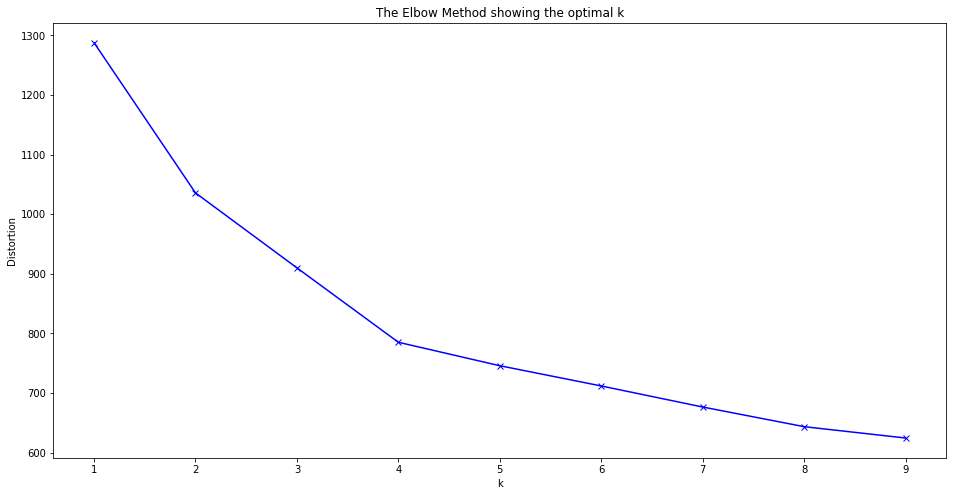

In [48]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [49]:
kmeans_model = KMeans(n_clusters=6)
kmeans_model.fit(df_norm.values)
centers = np.array(kmeans_model.cluster_centers_)

In [50]:
for c in centers:
    print(c[-1])

0.4300595238095238
0.4901021711366539
0.5228888888888888
0.49
0.5582031249999999
0.47599388379204893


In [ ]:
for c in centers:
    print(c)

In [57]:
def get_result(c):
    branch = names_branch[int(round(c[0] * 2, 1))]
    ct = names_ct[int(round(c[1], 0))]
    gender = names_gender[int(round(c[2], 0))]
    pl = names_pl[int(round(c[3] * 5, 0))]
    payment = names_payment[int(round(c[7] * 2, 1))]
    unit_price = c[4] * dff['Unit price'].max()
    quantity = c[5] * dff['Quantity'].max()
    cogs = c[6] * dff['cogs'].max()
    print(branch, ct, gender, pl, payment, unit_price, quantity, cogs)

In [81]:
def get_result(c):
    payment = names_payment[int(round(c[0] * 2, 1))]
    print(payment)

In [58]:
get_result(centers[3])

A Member Male Food and beverages Credit card 51.81856853582555 4.874999999999999 294.7395061963921


In [68]:
X_out = min_max_scaler.inverse_transform(centers)
X_out = np.around(X_out, 2)
df_out = pd.DataFrame(X_out)
df_out.columns = dff.columns
df_out

,Branch,Customer type,Gender,Product line,Unit price,Quantity,cogs,Payment,Rating
0,0.80,1.0,-0.0,2.41,59.08,6.33,373.46,1.71,6.58
1,1.06,0.0,0.0,2.61,55.78,5.72,321.65,0.97,6.94
2,0.85,1.0,1.0,2.75,54.31,4.67,249.79,1.70,7.14
3,0.94,0.0,1.0,2.41,56.67,5.39,301.89,1.01,6.94
4,1.18,1.0,-0.0,2.12,50.88,5.22,266.50,0.31,7.35
5,1.07,1.0,1.0,2.17,57.22,5.94,346.58,0.19,6.86


In [145]:
def uncat(x, cat):
    dict_cats = {
        'Branch': {0 : 'A', 1: 'B', 2: 'C'},
        'Customer type': {0 : 'Member', 1: 'Normal'},
        'Gender': {0 : 'Female', 1: 'Male'},
        'Product line': {0 : 'Electronic accessories', 1: 'Fashion accessories', 2: 'Food and beverages', 3: 'Health and beauty', 4: 'Home and lifestyle', 5: 'Sports and travel'},
        'Payment': {0 : 'Cash', 1: 'Credit card', 2: 'Ewallet'}
    }
    c1 = int(x)
    c2 = c1 + 1
    p2 = np.around(x % 1, 2)
    p1 = 1 - p2
    if np.allclose(p1, 1, 0.001) == True:
        out = f'{int(p1 * 100)}% {dict_cats[cat][c1]}'
    else:
        out = f'{int(p1 * 100)}% {dict_cats[cat][c1]} <> {int(p2 * 100)}% {dict_cats[cat][c2]}'
    return(out)

def map_distribution(df):
    cat_features = ['Branch', 'Customer type', 'Gender', 'Product line', 'Payment']
    for c_name, _ in df.iteritems():
        if c_name in cat_features:
            df[c_name] = df[c_name].apply(lambda x: uncat(x, c_name))
    return(df)

In [125]:
dff.head()

,Branch,Customer type,Quantity,cogs,Payment,Rating
0,0,0,7,522.83,2,9.1
1,2,1,5,76.40,0,9.6
2,0,1,7,324.31,1,7.4
3,0,0,8,465.76,2,8.4
4,0,1,7,604.17,2,5.3


In [146]:
from copy import copy
dft = copy(dff)
dft = map_distribution(dft)
dft.head()

,Branch,Customer type,Quantity,cogs,Payment,Rating
0,100% A,100% Member,7,522.83,100% Ewallet,9.1
1,100% C,100% Normal,5,76.40,100% Cash,9.6
2,100% A,100% Normal,7,324.31,100% Credit card,7.4
3,100% A,100% Member,8,465.76,100% Ewallet,8.4
4,100% A,100% Normal,7,604.17,100% Ewallet,5.3
